<a href="https://colab.research.google.com/github/alfcan/CADOCS_NLU_Model/blob/feat%2Fml%2FNLP-pipeline/CADOCS_NLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
# Installation of the libraries which we'll use: HuggingFace Transformers, Datasets and Evaluate
!pip install -q transformers datasets evaluate

In [133]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tqdm import trange

import pandas as pd
import numpy as np

In [134]:
root = "https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/dev/augmented_dataset.csv"

df = pd.read_csv(root, sep = ';')
label_mapping = {'get_smells': 0, 'get_smells_date': 1, 'report': 2, 'info': 3}
df['intent'] = df['intent'].map(label_mapping)

In [135]:
request = df.request.values
intent = df.intent.values

In [136]:
# Divide the dataset into train and test sets
# Test set is divided into a test set and a validation set
test_ratio = 0.3
val_ratio = 0.33

batch_size = 16

# Indices of the train set and temp set (validation + test sets) splits stratified by labels
train_request, temp_request, train_intent, temp_intent = train_test_split(
    request,
    intent,
    test_size = test_ratio,
    shuffle = True,
    stratify = intent)

# We divide then temp_idx in test_idx (test set) and val_idx ( validation set)
test_request, val_request, test_intent, val_intent = train_test_split(
    temp_request,
    temp_intent,
    test_size = val_ratio,
    shuffle = True,
    stratify = temp_intent)

<Axes: >

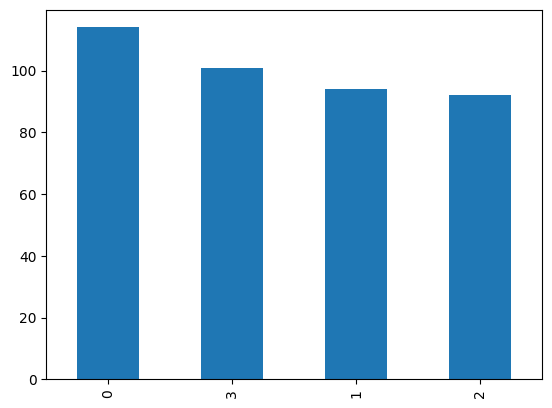

In [137]:
import matplotlib.pyplot as plt

# Convert NumPy array to a Pandas Series object
train_intent_series = pd.Series(train_intent)

# Creates a bar graph for counting the occurrences of each unique value
train_intent_series.value_counts().plot(kind='bar')

In [138]:
'''
# Tokenizer of BERT
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)
'''

# Tokenizer of RoBERTa
tokenizer = RobertaTokenizer.from_pretrained(
    'roberta-base',
    do_lower_case = True
)

In [139]:
# Tokenize each set splitted
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

def preprocessing_batch(data_set):
    token_id = []
    attention_masks = []
    for sample in data_set:
      encoding_dict = preprocessing(sample, tokenizer)
      token_id.append(encoding_dict['input_ids'])
      attention_masks.append(encoding_dict['attention_mask'])
    token_id = torch.cat(token_id, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    return token_id,attention_masks

train_token_id,train_attention_masks = preprocessing_batch(train_request)
test_token_id,test_attention_masks = preprocessing_batch(test_request)
val_token_id,val_attention_masks = preprocessing_batch(val_request)

train_intent = torch.tensor(train_intent)
test_intent = torch.tensor(test_intent)
val_intent = torch.tensor(val_intent)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [140]:
batch_size = 16

# Train, validation and test sets
train_set = TensorDataset(train_token_id,
                          train_attention_masks,
                          train_intent)

val_set = TensorDataset(val_token_id,
                        val_attention_masks,
                        val_intent)

test_set = TensorDataset(test_token_id,
                        test_attention_masks,
                        test_intent)

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [141]:
'''
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)
'''

# Load the RobertaForSequenceClassification model
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 3e-5,
                              eps = 1e-10
                              )

model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should pr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [142]:
# Load the metrics
import evaluate

accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
mcc_metric = evaluate.load('matthews_correlation')

# Compute of metrics
def compute_metrics(logits, label_ids):
  preds = np.argmax(logits, axis=1)
  val_accuracy = accuracy_metric.compute(predictions=preds, references=label_ids)['accuracy']
  val_precision = precision_metric.compute(predictions=preds, references=label_ids, average='macro')['precision']
  val_recall = recall_metric.compute(predictions=preds, references=label_ids, average='macro')['recall']
  val_mcc = mcc_metric.compute(predictions=preds, references=label_ids)['matthews_correlation']

  return val_accuracy, val_precision, val_recall, val_mcc

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 3

for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        #reset gradient value for the new epoch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

    # Calculate validation metrics
    val_accuracy, val_precision, val_recall, val_mcc = compute_metrics(logits, label_ids)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(val_accuracy))
    print('\t - Validation Precision: {:.4f}'.format(val_precision))
    print('\t - Validation Recall: {:.4f}'.format(val_recall))
    print('\t - Validation MCC: {:.4f}\n'.format(val_mcc))

# Save the trained model to a file
PATH = './bert.pth'
torch.save(model, PATH)

Epoch:  33%|███▎      | 1/3 [00:03<00:07,  3.76s/it]


	 - Train loss: 0.8601
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation MCC: 1.0000



Epoch:  67%|██████▋   | 2/3 [00:09<00:04,  4.64s/it]


	 - Train loss: 0.0625
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation MCC: 1.0000



Epoch: 100%|██████████| 3/3 [00:13<00:00,  4.36s/it]


	 - Train loss: 0.0115
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation MCC: 1.0000



In [144]:
# load the model saved
PATH = './bert.pth'
model = torch.load(PATH)

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    eval_output = model(b_input_ids,
                        token_type_ids = None,
                        attention_mask = b_input_mask)
    logits = eval_output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

# Calculate validation metrics
val_accuracy, val_precision, val_recall, val_mcc = compute_metrics(logits, label_ids)

print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
print('\t - Validation Accuracy: {:.4f}'.format(val_accuracy))
print('\t - Validation Precision: {:.4f}'.format(val_precision))
print('\t - Validation Recall: {:.4f}'.format(val_recall))
print('\t - Validation MCC: {:.4f}\n'.format(val_mcc))


	 - Train loss: 0.0115
	 - Validation Accuracy: 1.0000
	 - Validation Precision: 1.0000
	 - Validation Recall: 1.0000
	 - Validation MCC: 1.0000



In [145]:
# Input testing
requests_smells = [
                    "Hello CADOCS, which community smells have this project LINK?",
                    "Hi CADOCS, give me the community smells on this project LINK",
                    "CADOCS, community smells on the project LINK?",
                    "Give me code smells on repository LINK"
                  ]

requests_smells_date = [
                        "Hello CADOCS, which community smells have this project LINK after 18/05/2022?",
                        "Hi CADOCS, give me the community smells after DATE on this project LINK",
                        "CADOCS, community smells starting from 10/06/2022 on the project LINK?",
                        "Give me code smells on LINK after 06/02/2020"
                       ]

requests_report = [
                    "Hello CADOCS, can you give me the report of the last execution?",
                    "CADOCS, give me the report of the last execution",
                    "Hi CADOCS, give me the last execution",
                    "Give me the report of the last execution"
                  ]

requests_info =   [
                    "CADOCS what are community smells?",
                    "What can you do?",
                    "Which types of community smells can you return?",
                    "Hi CADOCS, what can you do?",
                    "Talk me about community smells"
                  ]

requests_arrays = [requests_smells, requests_smells_date, requests_report, requests_info]
array_names = ['requests_smells', 'requests_smells_date', 'requests_report', 'requests_info']

for requests, array_name in zip(requests_arrays, array_names):
  print("\nArray:", array_name)

  for request in requests:
    request_ids = tokenizer.encode_plus(
                            request,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                      )

    input_ids = torch.clone(request_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output = model(input_ids)

    predictions = output.logits.detach().cpu().numpy()
    predicted_class = np.argmax(predictions, axis = 1).flatten()

    for label, index in label_mapping.items():
        if index == predicted_class:
            predicted_label = label
            break

    print("Predicted class: " + predicted_label + " --- " + request)


Array: requests_smells
Predicted class: get_smells --- Hello CADOCS, which community smells have this project LINK?
Predicted class: get_smells --- Hi CADOCS, give me the community smells on this project LINK
Predicted class: get_smells --- CADOCS, community smells on the project LINK?
Predicted class: get_smells --- Give me code smells on repository LINK

Array: requests_smells_date


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predicted class: get_smells_date --- Hello CADOCS, which community smells have this project LINK after 18/05/2022?
Predicted class: get_smells_date --- Hi CADOCS, give me the community smells after DATE on this project LINK
Predicted class: get_smells_date --- CADOCS, community smells starting from 10/06/2022 on the project LINK?
Predicted class: get_smells_date --- Give me code smells on LINK after 06/02/2020

Array: requests_report
Predicted class: report --- Hello CADOCS, can you give me the report of the last execution?
Predicted class: report --- CADOCS, give me the report of the last execution
Predicted class: report --- Hi CADOCS, give me the last execution
Predicted class: get_smells --- Give me the report of the last execution

Array: requests_info
Predicted class: info --- CADOCS what are community smells?
Predicted class: info --- What can you do?
Predicted class: get_smells --- Which types of community smells can you return?
Predicted class: info --- Hi CADOCS, what can you